In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datasets import load_dataset

In [2]:
repo_id = "kuleshov-group/cross-species-single-nucleotide-annotation"

In [3]:
data = load_dataset(repo_id, data_files={"valid": "Evolutionary_constraint/valid.tsv"})
df = data["valid"].to_pandas()
REF = df["sequences"].str[255]

In [4]:
REF.head()

0    T
1    A
2    C
3    T
4    G
Name: sequences, dtype: object

In [5]:
models = ["pcv2_l24_d0768", "pcv2_l48_d1024", "pcv2_l48_d1536"]
ctx_window = ["512", "1024", "2048", "4096", "8192"]

In [6]:
for ctx in ctx_window:
    for model in models:
        print(f"Processing {model} of context {ctx}......")
        if ctx in ["4096", "8192"]:
            logitPath = f"../../../results/evolutionary_constraint/2nd/valid_{ctx}_{model}_logits_batchSize_32.tsv"
        else:
            logitPath = f"../../../results/evolutionary_constraint/valid_{ctx}_{model}_logits.tsv"
        logits = pd.read_csv(logitPath, header=None, sep="\t")
        logits.columns = ["A", "C", "G", "T"]
        scores = df.apply(
            lambda row: logits.loc[row.name, REF.loc[row.name]]
            if REF.loc[row.name] in "ATCG"
            else 0,
            axis=1,
        )
        prefix = f"{ctx}_{model}"
        df[prefix] = scores

Processing pcv2_l24_d0768 of context 512......
Processing pcv2_l48_d1024 of context 512......
Processing pcv2_l48_d1536 of context 512......
Processing pcv2_l24_d0768 of context 1024......
Processing pcv2_l48_d1024 of context 1024......
Processing pcv2_l48_d1536 of context 1024......
Processing pcv2_l24_d0768 of context 2048......
Processing pcv2_l48_d1024 of context 2048......
Processing pcv2_l48_d1536 of context 2048......
Processing pcv2_l24_d0768 of context 4096......
Processing pcv2_l48_d1024 of context 4096......
Processing pcv2_l48_d1536 of context 4096......
Processing pcv2_l24_d0768 of context 8192......
Processing pcv2_l48_d1024 of context 8192......
Processing pcv2_l48_d1536 of context 8192......


## PlantCAD1

In [7]:
logitPath = "../../../results/evolutionary_constraint/valid_pcv1_logits.tsv"
logits = pd.read_csv(logitPath, header=None, sep="\t")
logits.columns = ["A", "C", "G", "T"]
scores = df.apply(
    lambda row: logits.loc[row.name, REF.loc[row.name]]
    if REF.loc[row.name] in "ATCG"
    else 0,
    axis=1,
)
df["pcv1"] = scores

## Evo2

In [8]:
logitPath = "../../../results/evolutionary_constraint/valid_8192_evo2_logits.tsv"
logits = pd.read_csv(logitPath, header=None, sep="\t")
logits.columns = ["A", "C", "G", "T"]
scores = df.apply(
    lambda row: logits.loc[row.name, REF.loc[row.name]]
    if REF.loc[row.name] in "ATCG"
    else 0,
    axis=1,
)
df["evo2"] = scores

In [9]:
df.head()

,chrom,pos,label,sequences,512_pcv2_l24_d0768,512_pcv2_l48_d1024,512_pcv2_l48_d1536,1024_pcv2_l24_d0768,1024_pcv2_l48_d1024,1024_pcv2_l48_d1536,...,2048_pcv2_l48_d1024,2048_pcv2_l48_d1536,4096_pcv2_l24_d0768,4096_pcv2_l48_d1024,4096_pcv2_l48_d1536,8192_pcv2_l24_d0768,8192_pcv2_l48_d1024,8192_pcv2_l48_d1536,pcv1,evo2
0,Chr10,5498904,1,TCTTTTCCTTGAATGATAAAATAGTCAAAATTACTGGAGTTTTTGC...,0.954505,0.816796,0.874793,0.946048,0.983622,0.993975,...,0.955040,0.998704,0.953613,0.929130,0.999269,0.953617,0.916980,0.999415,0.956999,0.107422
1,Chr10,54666195,1,AGTTTACCTCGGCAACAAGTAGGCGTATTCTATTGTCTGATGTCGC...,0.646180,0.619778,0.644627,0.691048,0.637387,0.623345,...,0.671942,0.617936,0.721378,0.636439,0.676699,0.715844,0.641352,0.689250,0.688582,0.304688
2,Chr10,5411004,1,ACCCAGATCCAAAAATTATTCTTGTGGCAGTAATAAGATCAATAGC...,0.205625,0.163324,0.196887,0.192993,0.122960,0.123181,...,0.999123,0.999791,0.999529,0.997924,0.999670,0.999518,0.999141,0.999779,0.999847,0.002518
3,Chr10,60898792,1,TCTCAAGTTAGCCGCCTCACCCCAAATCAGCAAGTAGAGGCCCATA...,0.259210,0.279303,0.279561,0.265792,0.280462,0.281066,...,0.260464,0.266385,0.212394,0.204382,0.211977,0.212930,0.194793,0.212957,0.218713,0.302734
4,Chr10,57310734,1,GTCTATCCAGCGGCAGGAGTTGCCAATCACTGAGTACATCTATGGT...,0.500941,0.689282,0.716596,0.468062,0.495504,0.920407,...,0.769340,0.940187,0.453143,0.906328,0.901223,0.371069,0.947280,0.891948,0.489600,0.116211


In [10]:
models = df.columns[4:].tolist()
y_true = df["label"]
results = []

for mdl in models:
    y_scores = df[mdl]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    if mdl == "evo2":
        context = 8192
    elif mdl == "pcv1":
        context = 512
    else:
        context = mdl.split("_")[0]
        mdl = "_".join(mdl.split("_")[1:])
    results.append({"model": mdl, "context": context, "roc_auc": roc_auc})
results_df = pd.DataFrame(results)

In [11]:
results_df

,model,context,roc_auc
0,pcv2_l24_d0768,512,0.622205
1,pcv2_l48_d1024,512,0.653538
2,pcv2_l48_d1536,512,0.669504
3,pcv2_l24_d0768,1024,0.635968
4,pcv2_l48_d1024,1024,0.675713
5,pcv2_l48_d1536,1024,0.693211
6,pcv2_l24_d0768,2048,0.650106
7,pcv2_l48_d1024,2048,0.698289
8,pcv2_l48_d1536,2048,0.712729
9,pcv2_l24_d0768,4096,0.657983


In [12]:
subsets_df = results_df[12:]
model_order = ["pcv1", "pcv2_l24_d0768", "pcv2_l48_d1024", "pcv2_l48_d1536", "evo2"]
subsets_df = subsets_df.set_index("model").reindex(model_order).reset_index()

In [13]:
logits = pd.read_csv("../../../res", header=None, sep="\t")

FileNotFoundError: [Errno 2] No such file or directory: '../../../res'

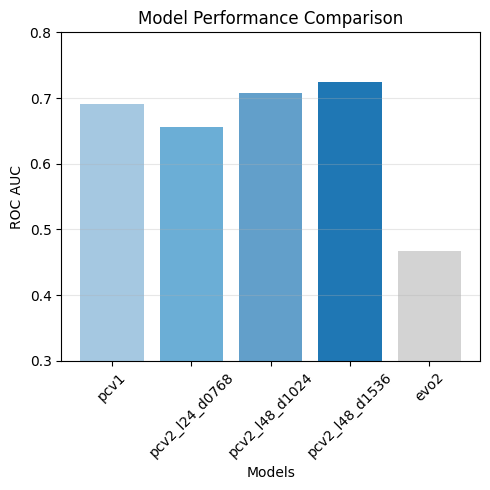

In [15]:
plt.figure(figsize=(5, 5))
colors = ["#1f77b466", "#6baed6", "#1f77b4b3", "#1f77b4ff", "#d3d3d3"]

bars = plt.bar(subsets_df["model"], subsets_df["roc_auc"], color=colors)

plt.xlabel("Models")
plt.ylabel("ROC AUC")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.ylim(0.3, 0.8)
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("valid_performance_8k.pdf", format="pdf", bbox_inches="tight")
plt.show()